In [1]:
import pandas as pd
import numpy as np
np.random.seed(3)
np.set_printoptions(suppress=True)
import matchms as mms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
random.seed(3)
import dreams.utils.spectra as su
from tqdm.auto import tqdm
tqdm.pandas()
from itertools import combinations
from dreams.definitions import MONA_PKL
from lsh import *
%load_ext autoreload
%autoreload 2

In [2]:
mona = pd.read_pickle(MONA_PKL)
mona = mona[mona['NUM PEAKS'] > 3]
mona = mona[~mona['PRECURSOR M/Z'].isna()]
mona = mona[mona['PARSED PEAKS'].apply(lambda pl: pl[0].max() <= 1000.)]
mona = mona.reset_index(drop=True)
mona['MMS Spectrum'] = mona.progress_apply(
    lambda row: mms.Spectrum(
        mz=row['PARSED PEAKS'][0],
        intensities=row['PARSED PEAKS'][1],
        metadata={'precursor_mz': row['PRECURSOR M/Z']}
    ), axis=1)
len(mona)

  0%|          | 0/73034 [00:00<?, ?it/s]

73034

In [3]:
mona = mona.sample(n=10_000).reset_index(drop=True)  # TODO: remove
df = []
for n_hyperplanes in tqdm([10, 20, 30, 40, 50]):
    for bin_step in [1., 0.05, 0.5]:
        lsh = PeakListRandomProjection(bin_step=bin_step, max_mz=1000., n_hyperplanes=n_hyperplanes)
        mona['LSH'] = mona['PARSED PEAKS'].apply(lambda pl: lsh.compute(pl))
        df.append({
            'Num. hyperplanes': n_hyperplanes,
            'Bin size': bin_step,
            'Unique LSH [%]': mona['LSH'].nunique() / len(mona) * 100
        })
df = pd.DataFrame(df)

  0%|          | 0/5 [00:00<?, ?it/s]

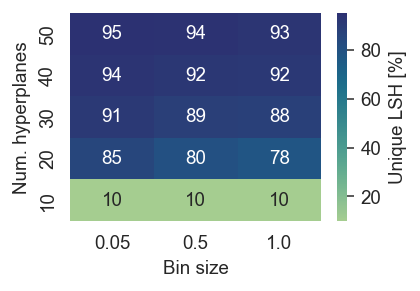

In [30]:
fig, ax=plt.subplots(1, 1, dpi=135, figsize=(3, 2))
sns.heatmap(df.pivot_table(values='Unique LSH [%]', columns='Bin size', index='Num. hyperplanes'), annot=True, cbar_kws={'label': 'Unique LSH [%]'}, cmap='crest')
ax.invert_yaxis()
plt.savefig('lsh_mona_heatmap.pdf', bbox_inches='tight')
plt.show()

In [5]:
cos_dist = mms.similarity.CosineGreedy(tolerance=0.5)
lsh = PeakListRandomProjection(bin_step=0.5, max_mz=1000., n_hyperplanes=30)
mona['LSH'] = mona['PARSED PEAKS'].progress_apply(lambda pl: lsh.compute(pl))
print(mona['LSH'].nunique(), len(mona))

  0%|          | 0/10000 [00:00<?, ?it/s]

8864 10000


In [6]:
lsh_counts = mona['LSH'].value_counts()
lsh_counts[:5]

181167085    22
571302913    16
937352177    16
739693979    15
630551550    12
Name: LSH, dtype: int64

In [7]:
max_pairs = 10
cos_scores_clashes = []
for lsh_clash_val in tqdm(lsh_counts[lsh_counts > 1].index):
    mona_clash_i = mona[mona['LSH'] == lsh_clash_val]
    if len(mona_clash_i) > max_pairs:
        mona_clash_i = mona_clash_i.sample(n=max_pairs)
    spec_pairs = combinations(mona_clash_i['MMS Spectrum'], 2)
    cos_scores_clashes.extend([float(cos_dist.pair(sp[0], sp[1])['score']) for sp in spec_pairs])
len(cos_scores_clashes)

  0%|          | 0/626 [00:00<?, ?it/s]

2245

In [8]:
cos_scores_different = []
for _ in tqdm(range(len(cos_scores_clashes))):
    i1 = random.randrange(0, len(mona))
    i2 = random.randrange(0, len(mona))
    while mona['LSH'][i1] == mona['LSH'][i2]:
        i2 = random.randrange(0, len(mona))
    cos_scores_different.append(float(cos_dist.pair(
        mona['MMS Spectrum'][i1],
        mona['MMS Spectrum'][i2]
    )['score']))

  0%|          | 0/2245 [00:00<?, ?it/s]

In [14]:
cos_scores_cl_closest = []

idx = mona.sample(n=100).index
for i in tqdm(idx):
    spec_i = mona['MMS Spectrum'][i]
    mona_i_diff = mona[mona['LSH'] != mona['LSH'][i]].copy()
    mona_i_diff['Cos to spec i'] = mona_i_diff['MMS Spectrum'].apply(
        lambda spec: float(cos_dist.pair(spec, spec_i)['score'])
    )

    j = mona_i_diff['Cos to spec i'].idxmax()
    print(mona_i_diff['Cos to spec i'][j], i, j, mona['LSH'][i], mona['LSH'][j])
    cos_scores_cl_closest.append((i, j, mona_i_diff['Cos to spec i'][j]))

  0%|          | 0/100 [00:00<?, ?it/s]

0.9717394729184562 9347 9315 1004465709 1004334637
0.9840380986545579 6826 6398 74482709 7898773
0.9783881078726476 2947 5497 579047866 580096442
0.9997767659099168 3507 1638 616221654 616287190
0.9602740816395825 4583 6374 110304718 103947614
0.9763483783670271 8499 6609 604316913 604308689
0.7658693697604405 8864 5682 1024088087 1036668567
0.8321383198417481 3332 196 414349105 415135525
0.7118309641751821 5528 4798 158415258 154216882
0.9563023665472583 2239 754 58863535 327298478
0.9932676548450743 4740 6192 804435517 804959805
0.9331997151380941 5987 2796 781313429 781280662
0.9753029193929624 6752 4699 1028639220 1030703600
0.8912172457862456 7238 2550 863179708 926096316
0.9158587983688565 443 7075 864227561 1000542217
0.9655572358178394 2305 9469 444775115 126960510
0.9980173366450059 1670 1534 970790772 972887892
0.9431820384755211 7627 2164 951620597 943297461
0.8659550544172292 2352 4045 632478362 633272970
0.9611300166653441 2556 6801 1049558932 1049542549
0.9967053399214821

0.9934570798523262
[[192.961697 100.      ]
 [ 61.011404  33.336202]
 [210.97229   30.776056]
 [148.971852  26.282964]
 [194.962801   5.124937]]
736266177


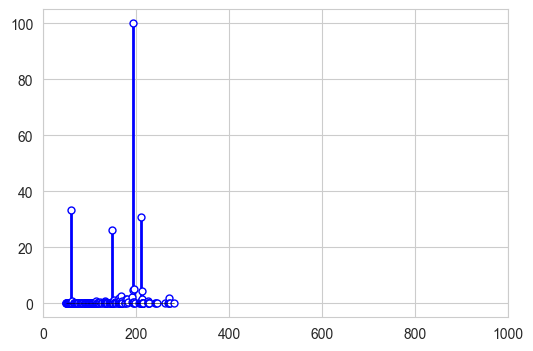

[[192.961631 100.      ]
 [210.972069  43.06442 ]
 [ 61.011379  38.4822  ]
 [148.971804  29.467445]
 [271.059953   6.784854]]
734168001


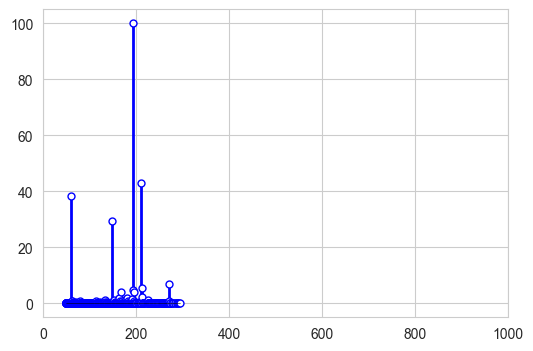

In [16]:
# i, j = 4175, 3165 # 0.99
# i, j = 5930, 4958 # 0.99
# i, j = 1477, 864 # 0.99 !
# i, j = 2599, 5017 # !
# i, j = 4557, 1348 # !
i, j = 1602, 4954 # !
print(float(cos_dist.pair(mona['MMS Spectrum'][i], mona['MMS Spectrum'][j])['score']))
for k in [i, j]:
    # print(mona['PARSED PEAKS'][k])
    print(su.get_highest_peaks(mona['PARSED PEAKS'][k], 5))
    print(lsh.compute(mona['PARSED PEAKS'][k]))
    su.plot_peak_list(mona['PARSED PEAKS'][k].T, plotly=False, xlim=(0, 1000))

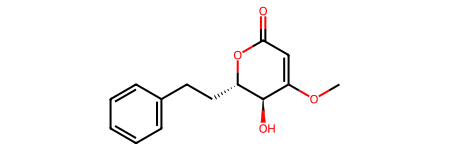

In [17]:
mona['ROMol'][i]

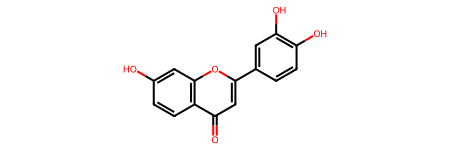

In [18]:
mona['ROMol'][j]

In [222]:
# lsh = PeakListRandomProjection(bin_step=0.5, max_mz=1000.)
# lsh_i = lsh.compute(mona['PARSED PEAKS'][i], as_int=False)
# lsh_j = lsh.compute(mona['PARSED PEAKS'][j], as_int=False)
# (lsh_i != lsh_j).sum()

2

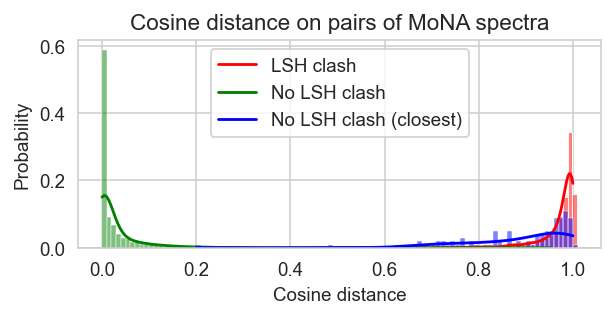

In [29]:
fig, ax=plt.subplots(1, 1, dpi=135, figsize=(5, 2))
sns.histplot(cos_scores_clashes, legend='LSH clash', fill=True, color='red', binwidth=0.01, stat='probability', kde=True)
sns.histplot(cos_scores_different, fill=True, color='green', binwidth=0.01, stat='probability', kde=True)
sns.histplot([e[2] for e in cos_scores_cl_closest], legend='closets', fill=True, color='blue', binwidth=0.01, stat='probability', kde=True)
plt.legend(['LSH clash', 'No LSH clash', 'No LSH clash (closest)'], loc='upper center')
ax.set_xlabel('Cosine distance')
# ax.set_yscale('log')
plt.title('Cosine distance on pairs of MoNA spectra')
plt.savefig('lsh_mona.pdf', bbox_inches='tight')
plt.show()